# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

### **Wait!** 
Aren't cifar100 and cifar10 mutually exclusive? 

(Yes, so we have an OOD set ready to be used. Yay!)

In [1]:
# Your code here.
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Here we define the ID dataset and Dataloader

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Now we load the CIFAR100 dataset for OOD sampling

In [3]:
# CIFAR-100 DATASET LOADING
batch_size = 32
#TODO: subset different classes for CIFAR-10
dataset_ood = CIFAR100(root='./data', train=False, download=True, transform=transform)

dl_ood = torch.utils.data.DataLoader(dataset_ood, batch_size=batch_size, shuffle=True, num_workers=2)



Files already downloaded and verified


A very simple CNN

In [4]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's now train the model from scratch

In [5]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)

# Train for only 50 epochs.
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop.
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over all batches.
    for (i, (Xs, ys)) in enumerate(dl_train, 0):
        Xs = Xs.to(device)
        ys = ys.to(device)
        
        # Make a gradient step.
        optimizer.zero_grad()
        outputs = model(Xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        
        # Track epoch loss.
        running_loss += loss.item()

    # Print average epoch loss.
    print(f'{epoch + 1} loss: {running_loss / len(dl_train):.3f}')

print('Finished Training')
torch.save(model.state_dict(), './cifar10_CNN.pth')

1 loss: 1.603
2 loss: 1.301
3 loss: 1.173
4 loss: 1.088
5 loss: 1.023
6 loss: 0.971
7 loss: 0.927
8 loss: 0.888
9 loss: 0.855
10 loss: 0.821
11 loss: 0.799
12 loss: 0.773
13 loss: 0.747
14 loss: 0.725
15 loss: 0.702
16 loss: 0.679
17 loss: 0.661
18 loss: 0.643
19 loss: 0.627
20 loss: 0.613
21 loss: 0.597
22 loss: 0.586
23 loss: 0.566
24 loss: 0.551
25 loss: 0.540
26 loss: 0.526
27 loss: 0.515
28 loss: 0.505
29 loss: 0.491
30 loss: 0.487
31 loss: 0.472
32 loss: 0.468
33 loss: 0.459
34 loss: 0.446
35 loss: 0.440
36 loss: 0.433
37 loss: 0.418
38 loss: 0.410
39 loss: 0.411
40 loss: 0.403
41 loss: 0.393
42 loss: 0.389
43 loss: 0.379
44 loss: 0.376
45 loss: 0.371
46 loss: 0.360
47 loss: 0.363
48 loss: 0.352
49 loss: 0.349
50 loss: 0.344
Finished Training


In [6]:
def test(model, dl):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (Xs, ys) in dl:
            Xs = Xs.to(device)
            ys = ys.to(device)
            outputs = model(Xs)
            _, predicted = torch.max(outputs, 1)
            total += ys.size(0)
            correct += (predicted == ys).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

In [7]:
test(model, dl_test)

Accuracy of the network on the 10000 test images: 59.02%


We now test the performances using the logit to score the OOD samples

In [8]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)

In [9]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_ood)

And now we plot the histogram of the scores!

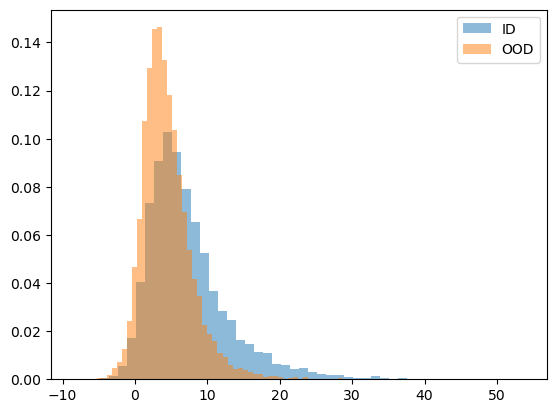

In [10]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

In [11]:
# OOD with max logit
threshold = 5
print(f'Accuracy: {(logits_ID.max(1) > threshold).mean() * 100:.2f}%') # Percentage of ID samples over 5 logit
print(f'OOD: {(logits_OOD.max(1) > threshold).mean() * 100:.2f}%') # Percentage of OOD samples over 5 logit

Accuracy: 60.28%
OOD: 36.33%


I'll use 5 as threshold for the OOD samples

In [12]:
detection = []
ground_truth = []

# Append 1 if the sample is detected as OOD, 0 otherwise
for i in logits_ID.max(1):
    if i > threshold:
        detection.append(1)
    else:  
        detection.append(0)

for i in logits_OOD.max(1):
    if i > threshold:
        detection.append(1)
    else:  
        detection.append(0)

# Now i create the ground thruth
for i in range(len(logits_ID.max(1))):
    ground_truth.append(1)

for i in range(len(logits_OOD.max(1))):
    ground_truth.append(0)

In [13]:
# Little check ìf the length is correct
print(len(detection))
print(len(ground_truth))

20000
20000


### Nice! ###

Let's now measure the performances using the AUROC metric and the AUPR metric

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


### AUROC ###

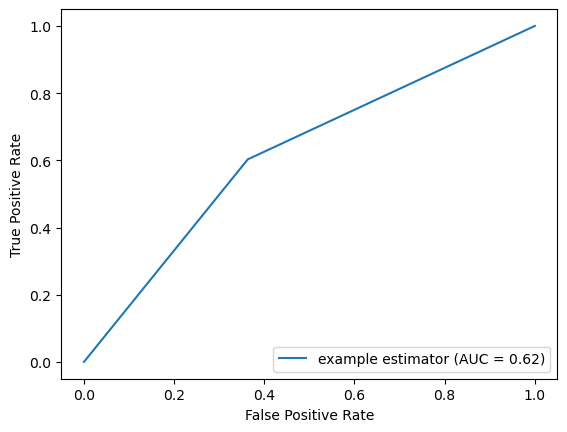

In [14]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(ground_truth, detection)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

### Precision-Recall ###

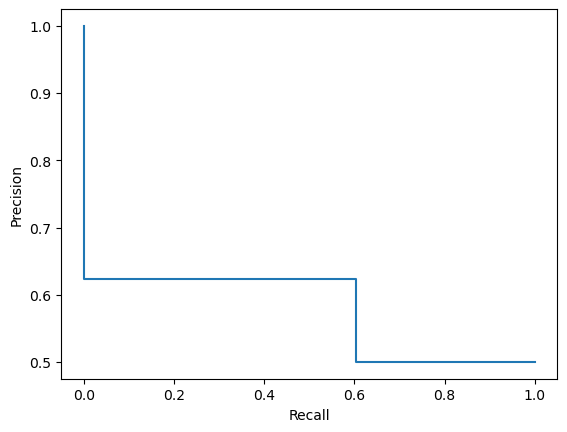

In [15]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(ground_truth, detection)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [16]:
# Your code here.

def fgsm_attack(model, dataloader, epsilon):
    perturbed_dataset = []
    accuracies = []
    model.requires_grad = False
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        data.requires_grad = True
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        perturbed_data = data + epsilon * data.grad.data.sign()
        #perturbed_data = torch.clamp(perturbed_data, 0, 1)  
        perturbed_dataset.append(perturbed_data)
        output_perturbed = model(perturbed_data)
        
        #loss_perturbed = criterion(output_perturbed, target)
        acc = (output_perturbed.argmax(1) == target).float().mean()
        accuracies.append(acc)
    average_accuracy = sum(accuracies) / len(accuracies)
    print(average_accuracy.item())
    return average_accuracy.item()
        

Now i gather perturbed data from the original dataset

In [17]:
import copy

epsilons = [0,0.05,0.1,0.2,0.3]
acc = []
model.eval()
accuracy = fgsm_attack(model, dl_test, epsilon=0)
for epsilon in (epsilons):
    print("Average accuracy for epsilon = ", epsilon, ":")
    acc.append(fgsm_attack(model, dl_test, epsilon=epsilon))


0.590355396270752
Average accuracy for epsilon =  0 :
0.590355396270752
Average accuracy for epsilon =  0.05 :
0.05491213873028755
Average accuracy for epsilon =  0.1 :
0.039037540555000305
Average accuracy for epsilon =  0.2 :
0.05221645161509514
Average accuracy for epsilon =  0.3 :
0.07088658213615417


5
5


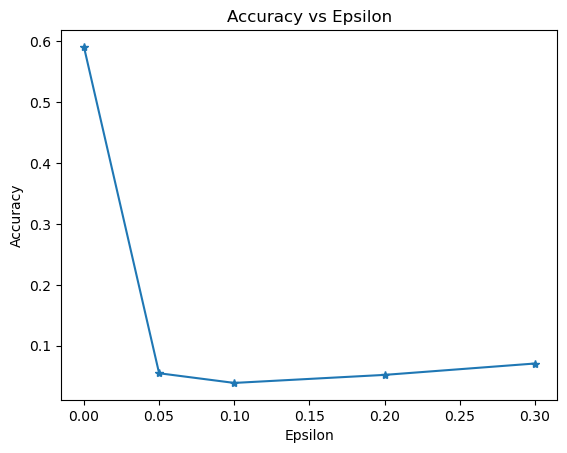

In [18]:
print(len(acc))
print(len(epsilons))

plt.plot(epsilons, acc, "*-")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [19]:
def fgsm_augmented(model, dataloader, epsilon, epochs):
    model.requires_grad = True
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)
            data.requires_grad = True
            model.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            perturbed_data = data + epsilon * data.grad.sign()
 
            output_perturbed = model(perturbed_data)
            loss_perturbed = criterion(output_perturbed, target)
            loss_perturbed.backward()
            optimizer.step()

    return model

In [20]:
model2 = CNN().to(device)
new_model = fgsm_augmented(model2, dl_train, epsilon=0.1, epochs=20)

Let's see how it performs on the OOD dataset now with the perturbed data

In [21]:
epsilons = [0,0.05,0.1,0.2,0.3]
acc = []
model.eval()
for epsilon in (epsilons):
    print("Average accuracy for epsilon = ", epsilon, ":")
    acc.append(fgsm_attack(new_model, dl_test, epsilon=epsilon))

Average accuracy for epsilon =  0 :
0.5967451930046082
Average accuracy for epsilon =  0.05 :
0.3102036714553833
Average accuracy for epsilon =  0.1 :
0.2995207607746124
Average accuracy for epsilon =  0.2 :
0.22344249486923218
Average accuracy for epsilon =  0.3 :
0.15924520790576935


5
5


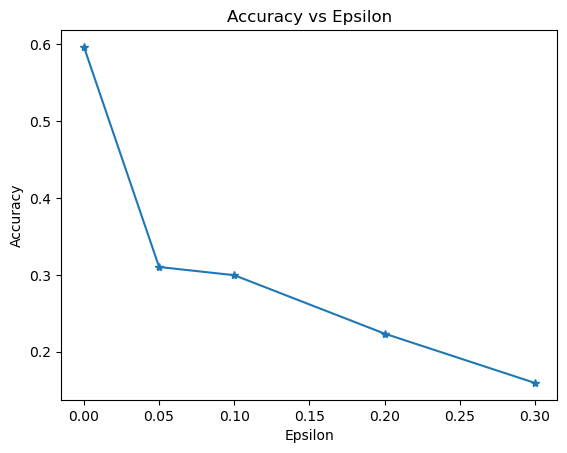

In [22]:
print(len(acc))
print(len(epsilons))

plt.plot(epsilons, acc, "*-")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


Cool! Let's try with another epsilon

In [23]:
model3 = CNN().to(device)
new_model = fgsm_augmented(model3, dl_train, epsilon=0.2, epochs=20)

In [24]:
epsilons = [0,0.05,0.1,0.2,0.3]
acc = []
model.eval()
for epsilon in (epsilons):
    print("Average accuracy for epsilon = ", epsilon, ":")
    acc.append(fgsm_attack(new_model, dl_test, epsilon=epsilon))

Average accuracy for epsilon =  0 :
0.5884584784507751
Average accuracy for epsilon =  0.05 :
0.0395367406308651
Average accuracy for epsilon =  0.1 :
0.18210862576961517
Average accuracy for epsilon =  0.2 :
0.6803115010261536
Average accuracy for epsilon =  0.3 :
0.6191093921661377


5
5


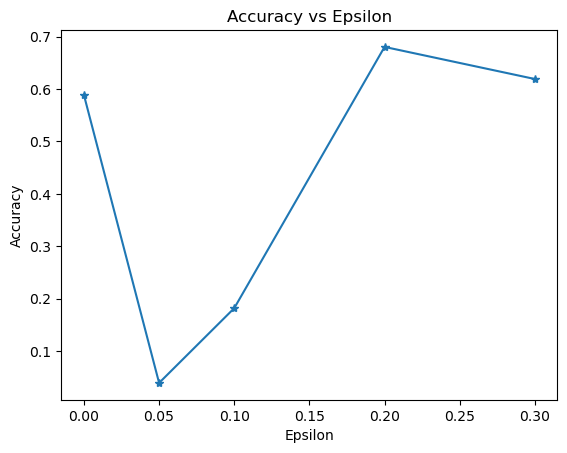

In [25]:
print(len(acc))
print(len(epsilons))

plt.plot(epsilons, acc, "*-")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


First i do a simple function just to detect ood samples

In [94]:
def odin_confidence(model, data, targets, epsilon, temperature,device):
        
    data = data.to(device)

    targets = targets.to(device)

        
    data.requires_grad = True
    outputs = model(data)
    outputs = outputs/temperature

    soft = torch.softmax(outputs, dim=1)
    max = torch.max(soft, dim=1)
    log = torch.log(max.values)
    
    log = log.sum()
    log.backward()

    # First we perturb the data
    perturbed_data = data - epsilon * -data.grad.data.sign()
        
    # Now we compute the perturbed outputs for scaling

    perturbed_outputs = model(perturbed_data)

    # Scale the output and do softamx
    
    confidence,_ = torch.max(perturbed_outputs, dim=1)
    return confidence


In [95]:
model = model.to(device)
temperature = 100
epsilon = 0.3
correct = 0
total = 0


for batch, target in dl_test:
    confidence = odin_confidence(model, batch, target, epsilon, temperature,device)
    correct += (confidence > epsilon).float().sum()
    total += len(batch)

for batch, target in dl_ood:
    confidence = odin_confidence(model, batch, target, epsilon, temperature,device)
    correct += (confidence <= epsilon).float().sum()
    total += len(batch)

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')






Accuracy of the network on the 20000 test images: 50.349998474121094%


In [ ]:
detection = []
ground_truth = []


And now, auroc!

In [ ]:
from sklearn import metrics

detection = detected_id + detected_ood

gt_id = [0] * len(detected_id)
gt_ood = [1] * len(detected_ood)
ground_truth = gt_id + gt_ood

fpr, tpr, thresholds = metrics.roc_curve(ground_truth, detection)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()